<a href="https://colab.research.google.com/github/CalistDsouza/Artificial-Intelligence-with-Machine-Learning/blob/main/image_deocclusion_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Name: Calist Dsouza
## id: N01717873

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:06<00:00, 27.4MB/s]


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.enc_relu1 = nn.ReLU()
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.enc_relu2 = nn.ReLU()
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder
        self.dec_convT1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_relu1 = nn.ReLU()
        self.dec_convT2 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_tanh = nn.Tanh()

    def forward(self, x):
        # Encoding
        x = self.enc_pool1(self.enc_relu1(self.enc_conv1(x)))
        x = self.enc_pool2(self.enc_relu2(self.enc_conv2(x)))

        # Decoding
        x = self.dec_relu1(self.dec_convT1(x))
        x = self.dec_tanh(self.dec_convT2(x))

        return x

In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.0121
Epoch [2/20], Loss: 0.0106
Epoch [3/20], Loss: 0.0098
Epoch [4/20], Loss: 0.0070
Epoch [5/20], Loss: 0.0087
Epoch [6/20], Loss: 0.0083
Epoch [7/20], Loss: 0.0068
Epoch [8/20], Loss: 0.0075
Epoch [9/20], Loss: 0.0077
Epoch [10/20], Loss: 0.0092
Epoch [11/20], Loss: 0.0070
Epoch [12/20], Loss: 0.0078
Epoch [13/20], Loss: 0.0064
Epoch [14/20], Loss: 0.0066
Epoch [15/20], Loss: 0.0070
Epoch [16/20], Loss: 0.0071
Epoch [17/20], Loss: 0.0055
Epoch [18/20], Loss: 0.0066
Epoch [19/20], Loss: 0.0061
Epoch [20/20], Loss: 0.0071


## first 10 img

In [ ]:
import copy
test_images = torch.stack([test_dataset[i][0] for i in range(10)]).to(device)
X = copy.deepcopy(test_images)


## Apply occlusion

In [ ]:
def add_occlusion(images):
    occluded = images.clone()
    for i in range(images.shape[0]):
        occl_row = np.random.randint(5, 20)
        occluded[i, :, occl_row:occl_row+1, :] = 1.0
    return occluded

In [ ]:
occluded_images = add_occlusion(X)

## de-occlusion


In [ ]:
with torch.no_grad():
    deoccluded_images = model(occluded_images)

In [ ]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    if title:
        plt.title(title)

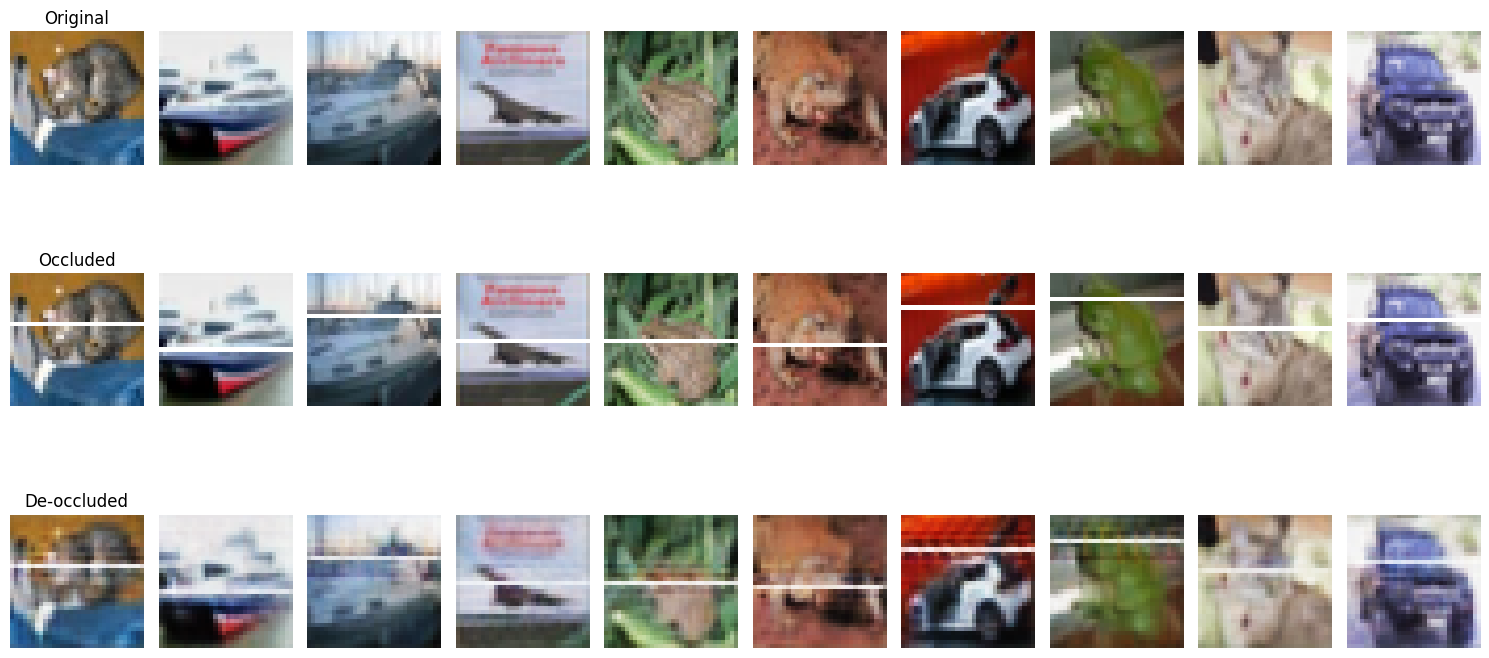

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(3, 10, i+1)
    imshow(test_images[i], 'Original' if i == 0 else None)

    plt.subplot(3, 10, i+11)
    imshow(occluded_images[i], 'Occluded' if i == 0 else None)

    plt.subplot(3, 10, i+21)
    imshow(deoccluded_images[i], 'De-occluded' if i == 0 else None)

plt.tight_layout()
plt.show()